In [1]:
from pathlib import Path

import pickle

from datetime import datetime

In [2]:
import lightning as L

from matplotlib import pyplot as plt

import numpy as np

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets
from torchvision.transforms import v2

from tqdm import tqdm

In [3]:
records_directory_path = Path.cwd() / 'records'

weights_file_path = records_directory_path / 'weights.pth'
losses_file_path = records_directory_path / 'losses.pkl'

# Data Processing

In [4]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

In [5]:
# Download Data from open datasets.
data = {
    split: datasets.CIFAR10(
        root='../dataset/',
        download=True,
        transform=transform,
    ) for split in ['train', 'val']
}

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Create Dataloaders
dataloaders = {
    split: DataLoader(
        dataset=data[split],
        batch_size=2 ** 10,
        num_workers=4,
    ) for split in ['train', 'val']
}

In [7]:
classes = [
    'plane',
    'car',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

# Model

In [8]:
class AlexNetCIFAR10(nn.Module):
    def __init__(self, n_classes = 10):
        super(AlexNetCIFAR10, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 3 * 3, 4096), 
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, n_classes) 
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [9]:
model = AlexNetCIFAR10()

In [10]:
if weights_file_path.exists():
    weights = torch.load(weights_file_path, weights_only=True)
    model.load_state_dict(weights)
    print("Model weights successfully recovered.")

Model weights successfully recovered.


# Hardware Acceleration

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using {device} device")

Using cuda device


# Optimizers

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

# Training

In [13]:
def training(model, dataloaders, device, epochs, optimizer, criterion):
    since = datetime.now()
    model.to(device)
    losses = {'train': [], 'val': []}

    for epoch in range(epochs):
        for split in ['train', 'val']:
            model.train() if split == 'train' else model.eval()

            running_loss = .0

            epoch_prefix = 'Training' if split == 'train' else 'Validation'
            prefix = f'{epoch_prefix:10} Epoch {epoch + 1:2}/{epochs}'

            for x, y in tqdm(dataloaders[split], desc=prefix):
                x, y = x.to(device), y.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(split == 'train'):
                    pred = model(x)
                    loss = criterion(pred, y)

                if split == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * x.size(0)
            epoch_loss = running_loss / len(data[split])
            losses[split].append(epoch_loss)
    time_elapse = datetime.now() - since
    print(f'Training complete in {time_elapse}')
    return losses

In [14]:
epochs = 5

if losses_file_path.exists():
    with open(losses_file_path, 'rb') as file:
        losses = pickle.load(file)
    print("Model losses successfully recovered.")
else:
    losses = training(
        model=model,
        dataloaders=dataloaders,
        device=device,
        epochs=epochs,
        optimizer=optimizer,
        criterion=criterion,
    )

Model losses successfully recovered.


## Recording

In [15]:
torch.save(model.state_dict(), weights_file_path)
print("Model weights successfully saved.")

Model weights successfully saved.


In [16]:
with open(losses_file_path, 'wb') as file:
    pickle.dump(losses, file)
    print("Model losses successfully saved.")

Model losses successfully saved.


## Graph

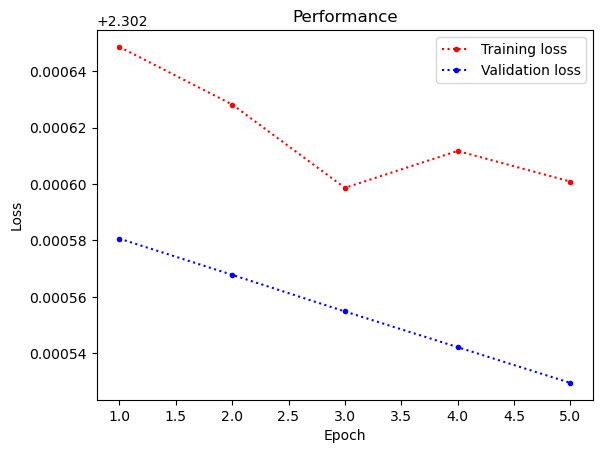

In [17]:
plt.figure()
plt.title('Performance')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(
    np.arange(1, epochs + 1),
    losses['train'],
    label='Training loss',
    color='red',
    marker='.',
    linestyle='dotted'
)
plt.plot(
    np.arange(1, epochs + 1),
    losses['val'],
    label='Validation loss',
    color='blue',
    marker='.',
    linestyle='dotted'
)
plt.legend()